# Deep Learning for Time Series Predictions

Deep learning has been shown to be a great (and risk adverse) way of model time series. In this notebook I will use an LSTM approach to modeling energy prices in the CAISO

In [84]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Denses
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1

In [2]:
path = './../../datasets/all_prices.csv'
df = pd.read_csv(path, header=None)
X = df.to_numpy()

# Preprocessing

LSTM's need to be fed time series data in an extremely specific way. This data format can be considered very similar to image processing in CNNs. However in the case of the LSTM, data feeds will be fed in a $m$ length timeseries, and the network will attempt to learn what the next $n$ steps of that timeseries should be. 

In order to gague what $m$ and $n$ should be you have to 1) identify the use case of the problem, and 2) do some EDA. In the case of energy prices, it is desireable to predict prices for a 48 hour period. This level of $n$ is normally what providors and buyers need to submit their buy-sell times on.

## EDA

In order to get a first idea of how much data to feed into the LSTM, I have plotted a few randomly selected time series to understand what the input, output might look like.

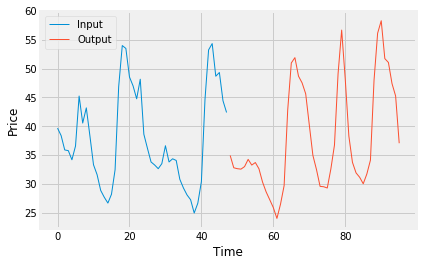

In [40]:
node = 133
start = 23
m = 48
n = 48

def plot_input_lstm(X, start, m, n, node):

    end_train = start + m
    end_test = end_train + n + 1
    t_in = np.arange(m)
    t_out = np.arange(n) + max(t_in) + 1
    input_y = X[node][start:end_train]
    output_y = X[node][end_train + 1:end_test]
    
    fig, ax = plt.subplots()
    ax.plot(t_in, input_y, label ='Input')
    ax.plot(t_out, output_y, label='Output')
    ax.set_ylabel('Price')
    ax.set_xlabel('Time')
    ax.legend()
    return fig, ax

fig, ax = plot_input_lstm(X, start, m, n, node)

The periodic nature of the data looks to be picked up with the 2 day input data, so I will use $m=48$ for my input into the LSTM (taking into account my limited computing power).

## Data Shaping

For data to be fed into an LSTM, it must be shaped correctly. The basics of this process is to take a single time series and loop through each day of the data, creating a single training instance similar to the graph above. For the keras implementation of LSTM that I will be using, the resulting dataset must then be reshaped again with numpy to be a valid input. Luckily, I have a pre-built function from college to do this for me :)

Also with LSTM specific preprocessing, standard preprocessing of test-train splitting, and Min Max scaling is going to be used in getting the data ready for the LSTM

### Test Train Split

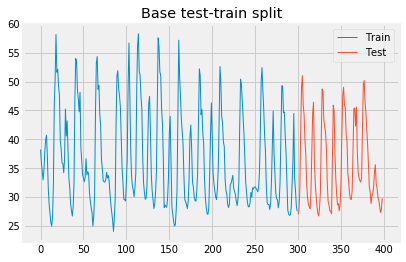

In [72]:
prices = X[node][0:400]
fraction_split = 0.75
train_stop = int(round(fraction_split*prices.shape[0]))
train = prices[0:train_stop]
test = prices[train_stop + 1:]

train_t = np.arange(train_stop)
test_t = np.arange(prices.shape[0] - train_stop - 1) + train_stop

fig, ax = plt.subplots()
ax.plot(train_t, train, label='Train')
ax.plot(test_t, test, label='Test')
ax.legend()
ax.set_title('Base test-train split')
plt.show()

### Min-Max Scaling

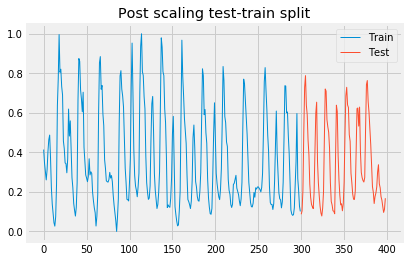

In [73]:
scaler = MinMaxScaler()
scaler.fit(train.reshape(-1,1))
train = scaler.transform(train.reshape(-1,1)).T[0]
test = scaler.transform(test.reshape(-1,1)).T[0]

fig, ax = plt.subplots()
ax.plot(train_t, train, label='Train')
ax.plot(test_t, test, label='Test')
ax.legend()
ax.set_title('Post scaling test-train split')
plt.show()

### LSTM Shaping

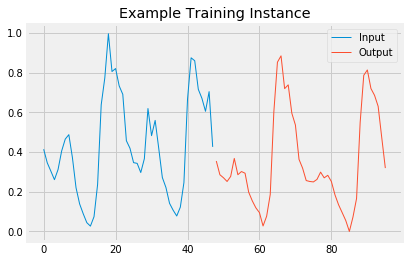

In [74]:
def split_training(timeseries, num_in, num_out):
    
    # intialize vectors for the input and output into the NN
    in_vec = []
    out_vec = []
    
    # determine how many training examples can be made
    num_instances = timeseries.shape[0] - num_in - num_out + 1
    
    # loop over the timeseries
    for i in range(num_instances):
        
        # input and output data for each instance
        data_inp = timeseries[i:num_in + i]
        data_out = timeseries[num_in + i:num_in + num_out+i]
        
        # store values
        in_vec.append(data_inp)
        out_vec.append(data_out)
    return np.array(in_vec), np.array(out_vec)

X_train, y_train = split_training(train, num_in=m, num_out=n)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test = split_training(test, num_in=m, num_out=n)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

ind = 0
train_ex = X_train[ind].T[0]
test_ex = y_train[ind]
t_train = np.arange(train_ex.shape[0])
t_test = np.arange(test_ex.shape[0]) + max(t_train) + 1

fig, ax = plt.subplots()
ax.plot(t_train, train_ex, label='Input')
ax.plot(t_test, test_ex, label='Output')
ax.legend()
ax.set_title('Example Training Instance')
plt.show()

# LSTM Modeling

## Base Case

In [44]:
# define model
features = 1
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(100, 
                               activation='relu', 
                               return_sequences=True, 
                               input_shape=(m, features)))
model.add(tf.keras.layers.LSTM(100, activation='relu'))
model.add(tf.keras.layers.Dense(n))
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 48, 100)           40800     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 48)                4848      
Total params: 126,048
Trainable params: 126,048
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
205/205 [==============================] - 11s 53ms/sample - loss: 0.3557
Epoch 2/100
205/205 [==============================] - 5s 27ms/sample - loss: 0.3164
Epoch 3/100
205/205 [==============================] - 5s 27ms/sample - loss: 0.2423
Epoch 4/100
205/205 [==============================] - 6s 27ms/sample - loss: 0.2111
Epoch 5/100
205/205 [==============================] - 6s 27ms/sample - loss: 0.1994
Epoch 6/100
205/205 [==============================] - 6s 27ms/sample - loss: 0.1957
Epoch 7/100
205/205 [==============================] - 6s 28ms/sample - loss: 0.1951
Epoch 8/100
205/205 [==============================] - 6s 28ms/sample - loss: 0.1940
Epoch 9/100
205/205 [==============================] - 6s 28ms/sample - loss: 0.1937
Epoch 10/100
205/205 [==============================] - 6s 28ms/sample - loss: 0.1935
Epoch 11/100
205/205 [==============================] - 6s 28ms/sample - loss: 0.1933
Epoch 12/100
205/205 [==============================] - 6s 28m

205/205 [==============================] - 6s 30ms/sample - loss: 0.0687
Epoch 97/100
205/205 [==============================] - 6s 29ms/sample - loss: 0.0679
Epoch 98/100
205/205 [==============================] - 6s 29ms/sample - loss: 0.0674
Epoch 99/100
205/205 [==============================] - 6s 29ms/sample - loss: 0.0674
Epoch 100/100
205/205 [==============================] - 6s 30ms/sample - loss: 0.0672


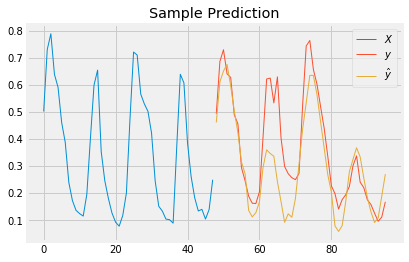

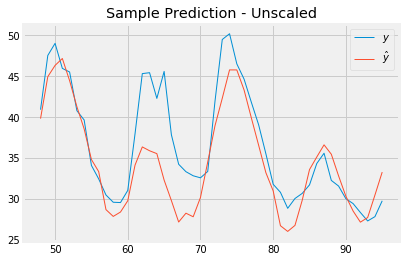

In [83]:
y_pred = model.predict(X_test)
y_pred_real = scaler.inverse_transform(y_pred)
y_test_real = scaler.inverse_transform(y_test)
ind = 3
fig, ax = plt.subplots()
ax.set_title('Sample Prediction')
ax.plot(t_train, X_test[ind].T[0], label='$X$')
ax.plot(t_test, y_test[ind], label='$y$')
ax.plot(t_test, y_pred[ind], label='$\hat{y}$')
ax.legend()
plt.show()
fig, ax = plt.subplots()
ax.set_title('Sample Prediction - Unscaled')
ax.plot(t_test, y_test_real[ind], label='$y$')
ax.plot(t_test, y_pred_real[ind], label='$\hat{y}$')
ax.legend()
plt.show()

## Performance Metrics

In [82]:
mae = np.mean(np.abs(y_pred_real - y_test_real))
mape = np.mean(np.abs((y_pred_real - y_test_real) / y_test_real)*100)
print(f'Testing MAE: {mae:.2f}')
print(f'Testing MAPE: {mape:.2f}')

Testing MAE: 3.06
Testing MAPE: 8.01
